# Tobigs 15기 Week7 NN 심화 - 15기 이성범

In [ ]:
# 패키기 불러오기
import sys
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [ ]:
# 재현가능성을 위한 seed 고정
def seed_everything(seed = 22):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)

  # torch 용
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

  # tensorflow 용
  tf.random.set_seed(seed)

seed_everything()

In [ ]:
paths = '/content/drive/MyDrive/Tobigs/'
train = pd.read_csv(paths + 'train.csv')
test = pd.read_csv(paths + 'test.csv')
submission = pd.read_csv(paths + 'sample_submission.csv')

# 데이터 확인

<Figure size 432x288 with 0 Axes>

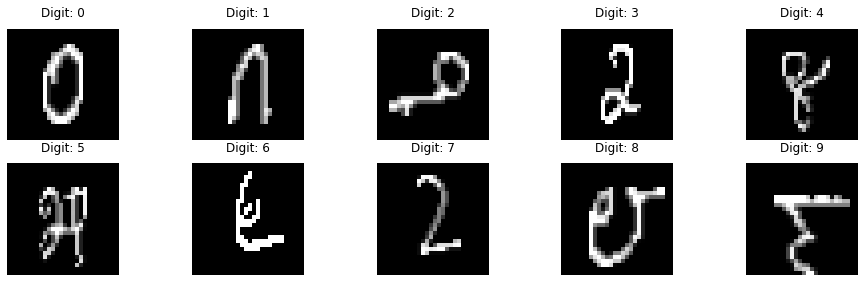

In [ ]:
# data를 각 픽셀에 이름붙여 표현
feat_cols = ['pixel'+str(i) for i in range(784)]

# 0~ 9 까지의 데이터 시각화
plt.gray()
fig = plt.figure(figsize=(16, 7))
for i in range(0,10):
    ax = fig.add_subplot(3, 5, i+1, title="Digit: {}".format(str(train[train['label']==i].loc[train[train['label']==i].index[0],'label'])) )
    ax.matshow(train[train['label']==i].loc[train[train['label']==i].index[0],feat_cols].values.reshape((28,28)).astype(float))
    ax.axis('off')
plt.show()

캐나다 원주민 글씨 데이터 셋이기 때문에 처음보는 알파벳이 많이 존재함

In [ ]:
# 딥러닝을 위한 데이터로 변환 후 정규화를 진행

X = train.drop('label',axis = 1).values.astype('float32') / 255.
y = train['label'].values

test = test.iloc[:,1:].values.astype('float32') / 255.

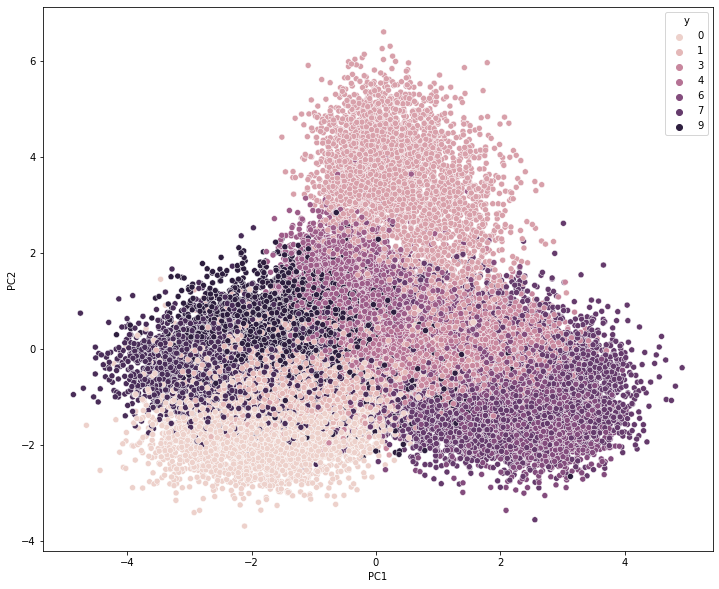

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)
df = pd.DataFrame(pca_X, columns=['PC1', 'PC2'])
df['y'] = y

plt.figure(figsize = (12, 10))
sns.scatterplot(x = 'PC1', y = 'PC2', data = df, hue='y')

In [ ]:
df['y'].value_counts()

3    4246
4    4232
7    4228
0    4202
1    4196
6    4193
8    4180
5    4177
2    4177
9    4169
Name: y, dtype: int64

생각보다 서로 비슷한 모양을 가지는 단어가 많은 것으로 판단된다.

# Pytorch

## ResNet을 활용

ResNet은 ILSVRC 대회에서 2015년에 우승한 모델로 지금 까지도 이미지 분류의 기본 모델로 널리 활용되고 있기 때문에 기본 ResNet을 가지고 이미지 분류를 함

In [ ]:
# 구글 코랩을 통해서 GPU를 이용한 학습을 함

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
img_rows = 28
img_cols = 28
num_classes = 10

## 데이터 전처리를 위한 함수 정의

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None, img_rows = 28, img_cols = 28):
    self.x_data = x_data.reshape(x_data.shape[0], 1, img_rows, img_cols)
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.LongTensor(self.y_data.reshape(-1,1)[idx])[0]
      return x, y

In [ ]:
dataset = CustomDataset(x_data = X, y_data = y)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

for (X_train, y_train) in dataloader:
  print(X_train.size())
  print(y_train.size())
  break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [ ]:
len(dataloader)

328

학습시에 활용되는 데이터 확인 1채널로된 이미지 데이터라는 것을 알 수 있음

## ResNet 모델 정의

참고
- 파이썬 딥러닝 피이토치(이경택 지음)

In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes,
                           kernel_size = 3,
                           stride = stride,
                           padding = 1,
                           bias = False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes,
                           kernel_size = 3,
                           stride = 1,
                           padding = 1,
                           bias = False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, planes,
                           kernel_size = 3,
                           stride = stride,
                           padding = 1,
                           bias = False),
          nn.BatchNorm2d(planes))
      
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_planes = 16
    
    self.conv1 = nn.Conv2d(1, 16,
                           kernel_size = 3,
                           stride = 1,
                           padding = 1,
                           bias = False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(16, 2, stride = 1)
    self.layer2 = self._make_layer(32, 2, stride = 2)
    self.layer3 = self._make_layer(64, 2, stride = 2)
    self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 7)
    out = out.view(out.size(0), -1)
    out = self.linear(out)

    return out

In [ ]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09)
costfuc = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

## 모델 훈련 시에 활용되는 함수 정의

In [ ]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  train_loss = 0
  correct = 0

  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = costfuc(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
        epoch, batch_idx * len(image), 
        len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
        loss.item()))
      
  train_loss /= len(train_loader.dataset)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

## 모델 평가 시에 활용되는 함수 정의

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += costfuc(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

## oof 기반의 모델 훈련

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


---------------------------------1번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.397053
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.055304

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0017, 	Train Accuracy: 94.96 %, 	Val Loss: 0.0008, 	Val Accuracy: 96.83 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.051718
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.014678

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.05 %, 	Val Loss: 0.0005, 	Val Accuracy: 97.83 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.005721
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.007269

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.27 %, 	Val Loss: 0.0002, 	Val Accuracy: 99.31 % 

Train Epoch: 4 [0/37800 (0%)]	Train Loss: 0.019069
Train Epoch: 4 [25600/37800 (68%)]	Train Loss: 0.007002

[EPOCH: 4], Lr: {0.001}	Train Loss: 0.0001, 	Train Accuracy: 99.39 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.48 % 

Train Epoch: 5 [0/37800 (0%)]	Train L

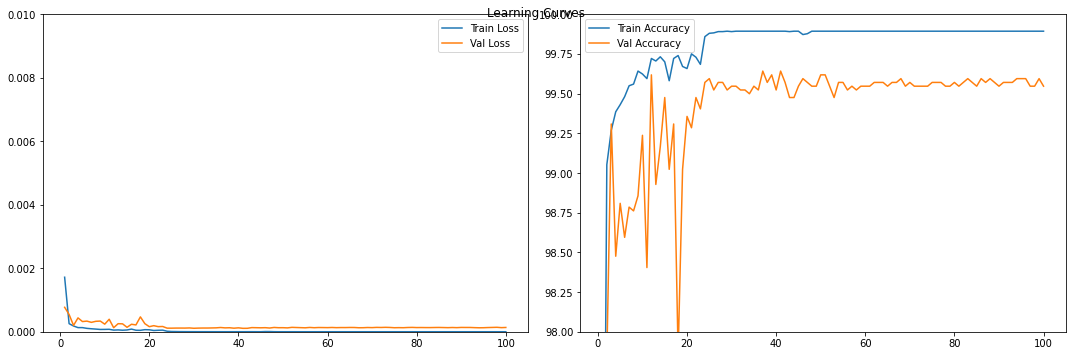

--------------------Best Model-------------------
Best Val Epoch:      41
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.6429
---------------------------------1번째 oof 종료-------------------------------
---------------------------------2번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.518293
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.052084

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0017, 	Train Accuracy: 95.18 %, 	Val Loss: 0.0006, 	Val Accuracy: 98.05 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.024397
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.041840

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.15 %, 	Val Loss: 0.0003, 	Val Accuracy: 99.12 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.008174
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.003992

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.26 %, 	Val Loss: 0.0003, 	Val Accuracy: 98.81 

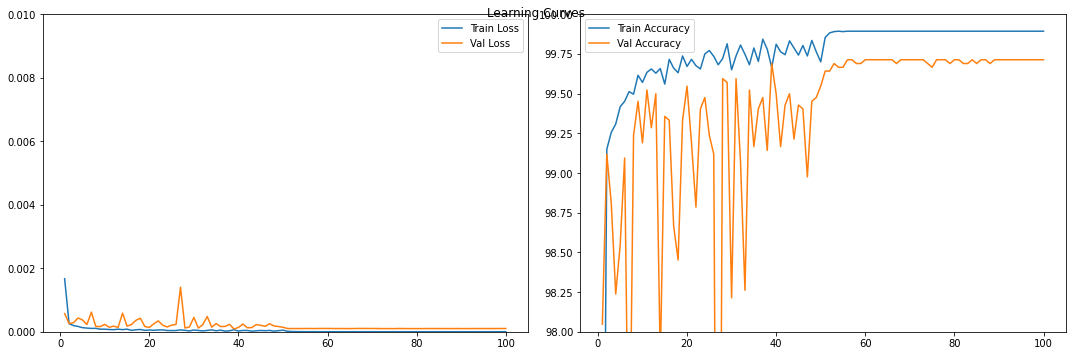

--------------------Best Model-------------------
Best Val Epoch:      100
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.7143
---------------------------------2번째 oof 종료-------------------------------
---------------------------------3번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.405060
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.016927

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0016, 	Train Accuracy: 95.49 %, 	Val Loss: 0.0005, 	Val Accuracy: 98.40 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.080341
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.065187

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.10 %, 	Val Loss: 0.0010, 	Val Accuracy: 96.21 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.039010
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.015837

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.21 %, 	Val Loss: 0.0002, 	Val Accuracy: 99.17

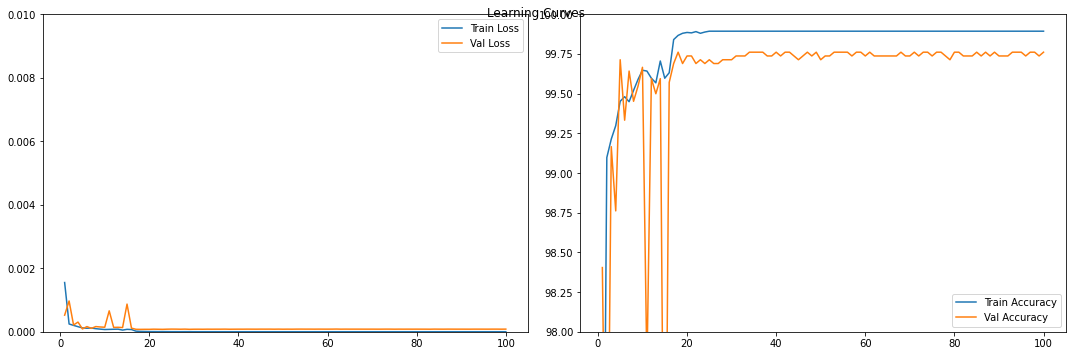

--------------------Best Model-------------------
Best Val Epoch:      100
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.7619
---------------------------------3번째 oof 종료-------------------------------
---------------------------------4번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.386204
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.112643

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0015, 	Train Accuracy: 95.83 %, 	Val Loss: 0.0003, 	Val Accuracy: 99.14 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.022892
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.029645

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.10 %, 	Val Loss: 0.0002, 	Val Accuracy: 99.29 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.024791
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.008349

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.30 %, 	Val Loss: 0.0006, 	Val Accuracy: 97.90

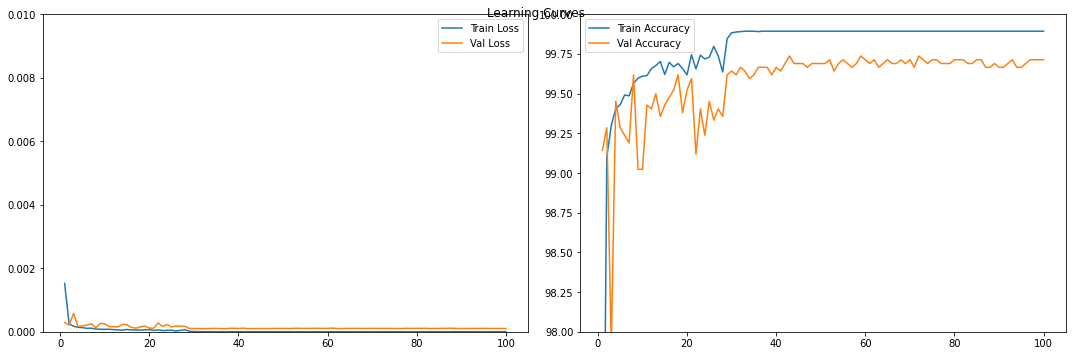

--------------------Best Model-------------------
Best Val Epoch:      72
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.7381
---------------------------------4번째 oof 종료-------------------------------
---------------------------------5번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.456702
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.040169

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0015, 	Train Accuracy: 95.84 %, 	Val Loss: 0.0006, 	Val Accuracy: 97.95 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.054936
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.042797

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.12 %, 	Val Loss: 0.0003, 	Val Accuracy: 99.05 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.077587
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.022839

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.26 %, 	Val Loss: 0.0003, 	Val Accuracy: 98.90 

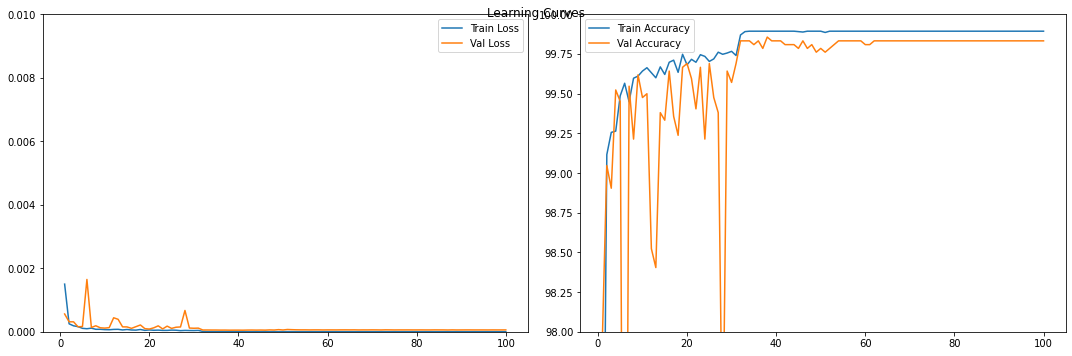

--------------------Best Model-------------------
Best Val Epoch:      38
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.8571
---------------------------------5번째 oof 종료-------------------------------
---------------------------------6번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.409117
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.049313

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0016, 	Train Accuracy: 95.47 %, 	Val Loss: 0.0004, 	Val Accuracy: 99.07 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.030420
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.013854

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.09 %, 	Val Loss: 0.0003, 	Val Accuracy: 98.98 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.019986
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.008859

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.26 %, 	Val Loss: 0.0003, 	Val Accuracy: 98.67 

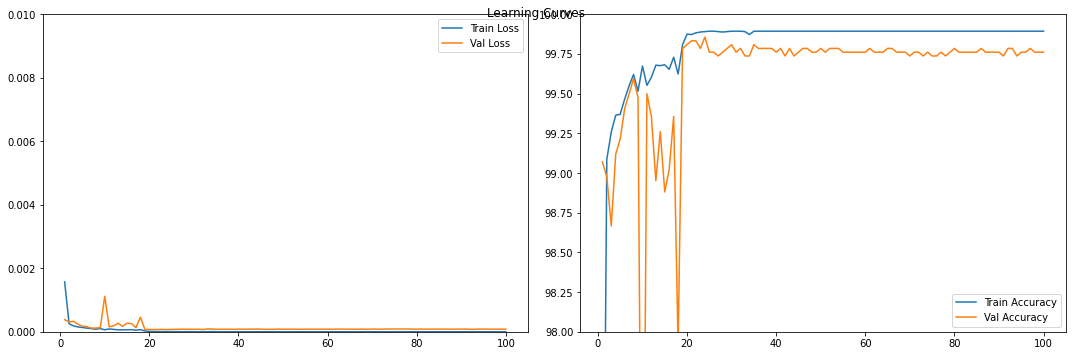

--------------------Best Model-------------------
Best Val Epoch:      24
Best Train Loss:     0.0000
Best Train Accuracy: 99.8915
Best Val Loss:       0.0001
Best Val Accuracy:   99.8571
---------------------------------6번째 oof 종료-------------------------------
---------------------------------7번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.343101
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.043181

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0016, 	Train Accuracy: 95.26 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.95 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.025102
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.045400

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.05 %, 	Val Loss: 0.0011, 	Val Accuracy: 95.55 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.066132
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.003841

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.31 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.60 

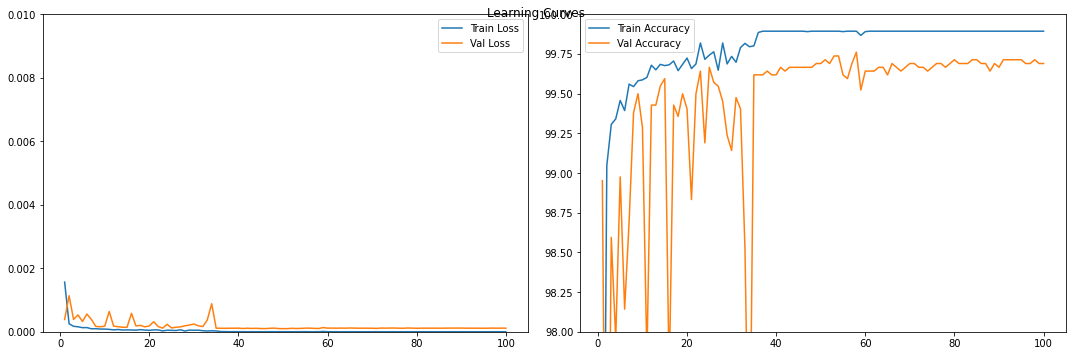

--------------------Best Model-------------------
Best Val Epoch:      58
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.7619
---------------------------------7번째 oof 종료-------------------------------
---------------------------------8번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.543158
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.037122

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0016, 	Train Accuracy: 95.67 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.86 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.026596
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.057930

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.03 %, 	Val Loss: 0.0003, 	Val Accuracy: 98.88 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.070253
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.049421

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.31 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.40 

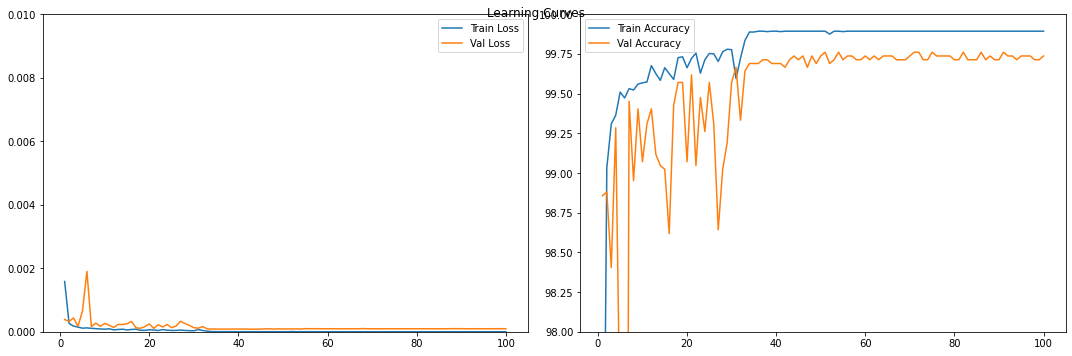

--------------------Best Model-------------------
Best Val Epoch:      91
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.7619
---------------------------------8번째 oof 종료-------------------------------
---------------------------------9번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.370371
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.044479

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0015, 	Train Accuracy: 95.68 %, 	Val Loss: 0.0005, 	Val Accuracy: 98.55 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.022146
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.045802

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.12 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.67 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.012108
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.027084

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.19 %, 	Val Loss: 0.0003, 	Val Accuracy: 98.90 

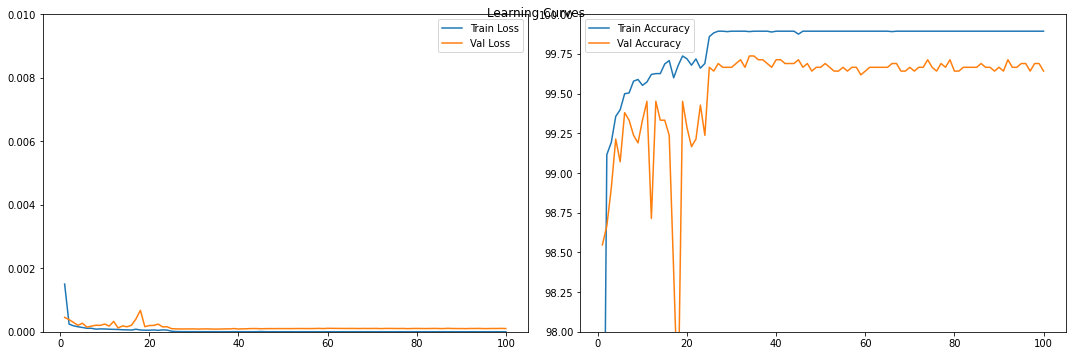

--------------------Best Model-------------------
Best Val Epoch:      35
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.7381
---------------------------------9번째 oof 종료-------------------------------
---------------------------------10번째 oof 시작-------------------------------
Train Epoch: 1 [0/37800 (0%)]	Train Loss: 2.429607
Train Epoch: 1 [25600/37800 (68%)]	Train Loss: 0.018254

[EPOCH: 1], Lr: {0.001}	Train Loss: 0.0016, 	Train Accuracy: 95.33 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.74 % 

Train Epoch: 2 [0/37800 (0%)]	Train Loss: 0.015703
Train Epoch: 2 [25600/37800 (68%)]	Train Loss: 0.025820

[EPOCH: 2], Lr: {0.001}	Train Loss: 0.0003, 	Train Accuracy: 99.12 %, 	Val Loss: 0.0003, 	Val Accuracy: 98.95 % 

Train Epoch: 3 [0/37800 (0%)]	Train Loss: 0.014365
Train Epoch: 3 [25600/37800 (68%)]	Train Loss: 0.081007

[EPOCH: 3], Lr: {0.001}	Train Loss: 0.0002, 	Train Accuracy: 99.25 %, 	Val Loss: 0.0004, 	Val Accuracy: 98.26

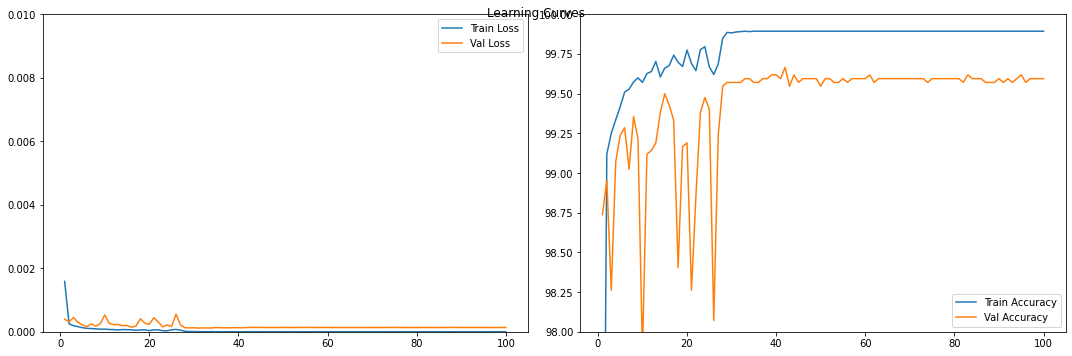

--------------------Best Model-------------------
Best Val Epoch:      42
Best Train Loss:     0.0000
Best Train Accuracy: 99.8942
Best Val Loss:       0.0001
Best Val Accuracy:   99.6667
---------------------------------10번째 oof 종료-------------------------------



In [ ]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook

# CV는 10으로
n_split = 10

# 균등하게 니눌때 사용
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

train_oof = np.zeros_like(y)
test_oof = np.zeros((test.shape[0], num_classes))

test_dataset = CustomDataset(test)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False)

cnt = 1

for trn_idx, val_idx in tqdm_notebook(skf.split(X, y)):
  trn_data, trn_label = X[trn_idx], y[trn_idx]
  val_data, val_label = X[val_idx], y[val_idx]

  train_dataset = CustomDataset(trn_data, trn_label)
  val_dataset = CustomDataset(val_data, val_label)
  test_dataset = CustomDataset(test)

  train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True)
  
  val_dataloader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False)
  
  print(f'---------------------------------{cnt}번째 oof 시작-------------------------------')

  model = ResNet().to(DEVICE)
  # optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-09)
  costfuc = nn.CrossEntropyLoss()

  best_val_accuracy = 0
  result_list = []

  for epoch in range(1, EPOCHS + 1):
    current_lrs = [x["lr"] for x in optimizer.param_groups]

    train_loss, train_accuracy = train(model, train_dataloader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print(f"\n[EPOCH: {epoch}], Lr: {set(current_lrs)}\tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {test_loss:.4f}, \tVal Accuracy: {test_accuracy:.2f} % \n")
    scheduler.step(test_loss)

    if best_val_accuracy <= test_accuracy:

      best_info = {
      'epoch': epoch,
      'model': deepcopy(model.state_dict()),
      'train_loss': train_loss,
      'train_metric': train_accuracy,
      'val_loss': test_loss,
      'val_metric': test_accuracy,
      }

      best_val_accuracy = test_accuracy
    
    result = {
        'epoch': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': test_loss,
        'Val Accuracy': test_accuracy
    }
    result_list.append(result)

  result_df = pd.DataFrame(result_list)

  # learning curve 그리기
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  fig.suptitle('Learning Curves')
  axes[0].plot(result_df['epoch'], result_df['Train Loss'], label='Train Loss')
  axes[0].plot(result_df['epoch'], result_df['Val Loss'], label='Val Loss')
  axes[0].set_ylim(0.0, 0.01)
  axes[0].legend()

  axes[1].plot(result_df['epoch'], result_df['Train Accuracy'], label='Train Accuracy')
  axes[1].plot(result_df['epoch'], result_df['Val Accuracy'], label='Val Accuracy')
  axes[1].set_ylim(98, 100)
  axes[1].legend()
  plt.tight_layout()
  plt.show()

  print("--------------------Best Model-------------------")
  print(f"Best Val Epoch:      {best_info['epoch']}")
  print(f"Best Train Loss:     {best_info['train_loss']:.4f}")
  print(f"Best Train Accuracy: {best_info['train_metric']:.4f}")
  print(f"Best Val Loss:       {best_info['val_loss']:.4f}")
  print(f"Best Val Accuracy:   {best_info['val_metric']:.4f}")

  model.load_state_dict(best_info['model'])
  model.eval()
  test_preds = []
  val_preds = []

  with torch.no_grad():

    for inputs in test_dataloader:
      test_preds.append(model(inputs.cuda()).cpu().numpy())

    for inputs, targets in val_dataloader:
      val_preds.append(model(inputs.cuda()).cpu().numpy().argmax(axis=1))

  train_oof[val_idx] = np.concatenate(val_preds)

  submission['Category'] = np.argmax(np.concatenate(test_preds), axis=1)
  submission.to_csv("ResNet_10_oof_"+str(cnt)+".csv",index=False)

  test_oof += np.concatenate(test_preds) / n_split

  print(f'---------------------------------{cnt}번째 oof 종료-------------------------------')
  cnt += 1

In [ ]:
from sklearn.metrics import accuracy_score

print('Train accuracy_score: ', accuracy_score(train_oof, y))

Train accuracy_score:  0.9975


In [ ]:
test_pred_labels = np.argmax(test_oof, axis=1)

submission['Category'] = test_pred_labels
submission.to_csv("ResNet_10_oof.csv",index=False)
submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [ ]:
np.save("test_oof_10.npy", test_oof)

Train Set: 0.99754

Test Set: 0.99772

더 많은 학습을 하면 좋지만 Colab을 사용하기 때문에 메모리와 시간상의 부족으로 100번만 학습했습니다. 아직 CNN에 대한 지식이 부족해서 더 나은 성능의 모델을 구성하지 못했습니다.

그리고 기존의 Adam만을 활용한 최적화보다는 ReduceLROnPlateau와 weight_decay를 적용했을 때 더 높은 성능 향상을 보여준다는 것을 발견했습니다. 데이터 증강의 경우 개인적으로 성능향상을 보였던 적이 많이 없어서 사용하지 않았습니다.

ReduceLROnPlateau를 사용한 이유는 일정 에폭을 넘으면 오버슛팅이 발생하여 학습률을 조정해주는 것이 전역 최적점에 다가는데 도움을 줄 수 있다고 생각하여 사용했습니다. ReduceLROnPlateau는 더 이상 성능의 향상이 없을 때 기존의 학습률에 factor를 곱해서 학습률을 조정해주는 방식입니다.

weight_decay는 모델의 가중치에 규제를 가함으로써 조금 더 일반화를 높여주기 때문에 사용하였습니다. 하지만 대체로 weight_decay를 사용하면 검증용 데이터에 대하여는 성능 향상을 보이지만 학습 데이터에 대한 성능은 하락하는 경향을 보입니다. 그러나 이번 데이터의 경우에는 학습 데이터에 대한 성능은 하락하지 않고 검증용 데이터에 대하여만 성능이 향상되는 아주 이상적인 결과를 보여줬습니다.

Adam, SGD, RMSProb 등의 최적화와 다양한 학습률 조정 scheduler를 사용하였지만 가장 성능이 좋았던 것은 Adam과 ReduceLROnPlateau의 결합이었습니다.

최종 예측 역시 두 가지를 활용했습니다.

https://www.kaggle.com/c/digit-recognizer/discussion/61480 를 참고하여 모델별 MNIST 최적의 성능을 비교해보았습니다.

- 99.5 % : 기본 CNN 모델을 활용한다면 가능하고 기본 학습을 30번으로 설정한다.
- 99.7 % : 설계가 잘 된 CNN 모델을 활용한다.(ResNet, AlexNet 등등)
- 99.79 % : 설계가 잘 된 CNN 모델 중 학습이 정말 기적적으로 잘 된 모델의 경우
- 99.8 % : 이 이상의 값은 Test 데이터를 훈련용 데이터로 활용해야 한다.(어떻게 보면 사기를 친다고 할 수 있다.)

라고 평가했습니다. 하지만 위 글은 3년전의 글이고 최근 댓글을 보면 설계가 잘 된 CNN 모델을 20개 앙상블 하여 99.8%의 벽을 꿰뚫는 경우도 존재하며 이외의 다른 설계까 잘된 CNN 모델을 활용하여 더 높은 성능을 보인 경우도 있으며 대부분의 성능 향상은 성능 좋은 CNN 모델의 앙상블이 기본적으로 활용되는 것 같습니다.

따라서 여기서 더 이상의 성능을 높이기 위해서는 Test 데이터를 훈련용 데이터로 활용하거나 더 나은 모델을 설계하고 기적적인 학습을 보인다면 99.8 이상의 성능을 보일것 입니다.




# keras 

oof 기반의 전이학습 방식의 모델을 활용 

1, 2, 3, 4, 5 <- 총 데이터 셋

## oof 1번째

model -> 학습이 진행되지 않은 상태

[2,3,4,5] ->  학습

[1] -> 평가

## oof 2번째

model -> oof 첫번째에 학습된 모델

[1,3,4,5] ->  학습

[2] -> 평가

## ....

위와 같은 방식으로 순차적으로 학습

## 데이터 전처리를 위한 함수 정의

In [ ]:
def preprocesing(x_trn_data, x_val_data, y_trn_data, y_val_data):

  img_rows = 28
  img_cols = 28

  x_train = x_trn_data.reshape(x_trn_data.shape[0], img_rows, img_cols, 1)
  x_test = x_val_data.reshape(x_val_data.shape[0], img_rows, img_cols, 1)

  # 예측 데이터는 0~9까지 총 10개
  num_classes = 10

  # 예측 데이터를 범주화 시킴
  y_train = keras.utils.to_categorical(y_trn_data, num_classes)
  y_test = keras.utils.to_categorical(y_val_data, num_classes)

  return x_train, x_test, y_train, y_test

## 모델 정의

Convolution Layer, BatchNormalization, Dropout 으로만 구성된 모델

https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist

In [ ]:
img_rows = 28
img_cols = 28

input_shape = (img_rows, img_cols, 1)

batch_size = 64

# 예측 데이터는 0~9까지 총 10개
num_classes = 10

# 30번 학습
epochs = 30

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

In [ ]:
def Net():

  model = Sequential()
  
  model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = input_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(32, kernel_size = 3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(64, kernel_size = 3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size = 3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(128, kernel_size = 4, activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

## oof 기반의 모델 훈련

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook

# CV는 5로
n_split = 5

# 균등하게 니눌때 사용
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

x_test = test.reshape(test.shape[0], img_rows, img_cols, 1)

train_oof = np.zeros_like(y)

test_oof = np.zeros((x_test.shape[0], num_classes))

cnt = 1

for trn_idx, val_idx in tqdm_notebook(skf.split(X, y)):
  trn_data, trn_label = X[trn_idx], y[trn_idx]
  val_data, val_label = X[val_idx], y[val_idx]

  print(f'---------------------------------{cnt}번째 oof 시작-------------------------------')

  trn_data, val_data, trn_label, val_label = preprocesing(trn_data, val_data, trn_label, val_label)

  hist = model.fit(trn_data, trn_label, 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   verbose=1, 
                   validation_data=(val_data, val_label))
  
  val_pred = model.predict(val_data)

  val_pred_labels = np.argmax(val_pred, axis=1)

  train_oof[val_idx] = val_pred_labels

  pred = model.predict(x_test)

  test_oof += pred / n_split

  print(f'---------------------------------{cnt}번째 oof 종료-------------------------------')
  cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


---------------------------------1번째 oof 시작-------------------------------
Epoch 1/30
525/525 [==============================] - 38s 9ms/step - loss: 0.5162 - accuracy: 0.8416 - val_loss: 0.0736 - val_accuracy: 0.9781
Epoch 2/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0577 - accuracy: 0.9834 - val_loss: 0.0322 - val_accuracy: 0.9896
Epoch 3/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0449 - accuracy: 0.9865 - val_loss: 0.0324 - val_accuracy: 0.9910
Epoch 4/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0291 - accuracy: 0.9912 - val_loss: 0.0310 - val_accuracy: 0.9920
Epoch 5/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.0205 - val_accuracy: 0.9943
Epoch 6/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0203 - val_accuracy: 0.9937
Epoch 7/30
525/525 [==============================] - 4s 8ms/step - loss

In [ ]:
from sklearn.metrics import accuracy_score

print('Train accuracy_score: ', accuracy_score(train_oof, y))

Train accuracy_score:  0.9983571428571428


In [ ]:
test_pred_labels = np.argmax(test_oof, axis=1)

submission['Category'] = test_pred_labels
submission.to_csv("CNN_oof.csv",index=False)
submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


Train Set: 0.99883

Test Set: 0.99722

전이학습 느낌으로 모델을 학습 시킨 것이기때문에 모델은 총 150번의 학습을 했습니다. 모델의 구성을 다르게 한다면 더 나은 성능을 보여줄 가능성이 존재합니다.

keras는 seed를 고정하여도 학습 재현이 안되기 때문에 Pytorch를 사용하는 것이 더 좋을 듯 합니다.